Add folder to path in order to load from the check_packages.py script:

Check recommended package versions:

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [3]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

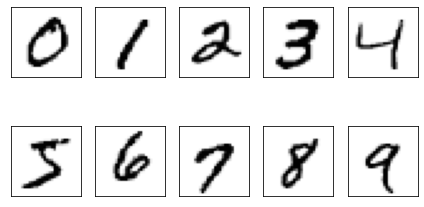

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

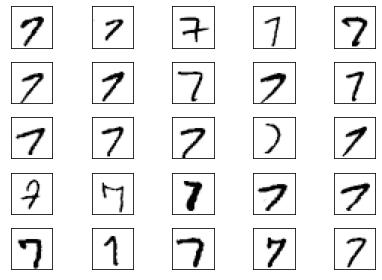

In [5]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

Split into training, validation, and test set:

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.7, random_state=123, stratify=y)

# X_train, X_valid, y_train, y_valid = train_test_split(
#     X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


# # optional to free up some memory by deleting non-used arrays:
# del X_temp, y_temp, X, y

<br>
<br>

## Implementing a multi-layer perceptron

In [7]:
import numpy as np

In [8]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)

In [9]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class TwoLayerNeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        self.weights = {}
        self.biases = {}
        
        self.weights['w1'] = rng.normal(
            loc=0.0, scale=0.1, size=(num_features, num_hidden))
        self.biases['b1'] = np.zeros(num_hidden)
                
        self.weights['w2'] = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_hidden))
        self.biases['b2'] = np.zeros(num_hidden)
        
        # output
        self.weights['w3'] = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_classes))
        self.biases['b3'] = np.zeros(num_classes)
        
    
    def linear(self, A, W, b):
        Z = np.dot(A, W) + b
        
        cache = (A, W, b)
        
        return Z, cache
    
    def sigmoid(self, Z):
        A = 1 / (1 + np.exp(-Z))
        
        cache = Z
        
        return A, cache
    
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        
        caches = []
        
        A = x
        for i in range(1, 4):
            Z, linear_cache = self.linear(A, self.weights[f'w{i}'], self.biases[f'b{i}'])
            A, activation_cache = self.sigmoid(Z)
            caches.append((linear_cache, activation_cache))
        
        return A, caches
    
    def linear_backward(self, dZ, cache):
        A_prev, W, b = cache
        dA_prev = dZ.dot(W.T)
        dW = A_prev.T.dot(dZ) / A_prev.shape[1]
        db = np.sum(dZ, axis=0) / A_prev.shape[1]
        
        return dA_prev, dW, db
    
    def sigmoid_backward(self, dA, cache):
        Z = cache
        s = 1 / (1 + np.exp(-Z))
        dZ = dA * s * (1 - s)
        
        return dZ

    def backward(self, AL, y, caches):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)
        L = len(caches)

        grads = {}
        
        loss = 2 * (AL - y_onehot)
        
        linear_cache, activation_cache = caches[L-1]
        
        dZ = self.sigmoid_backward(loss, activation_cache)
        dA_prev, dW, db = self.linear_backward(dZ, linear_cache)
        grads[f'dA{L-1}'] = dA_prev
        grads[f'dW{L}'] = dW
        grads[f'db{L}'] = db
        
        for l in reversed(range(L-1)):
            linear_cache, activation_cache = caches[l]
            dZ = self.sigmoid_backward(grads[f'dA{l+1}'], activation_cache)
            
            dA_prev, dW, db = self.linear_backward(dZ, linear_cache)
            grads[f'dA{l}'] = dA_prev
            grads[f'dW{l+1}'] = dW
            grads[f'db{l+1}'] = db

        return grads

In [10]:
model = TwoLayerNeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

## Coding the neural network training loop

Defining data loaders:

In [11]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

        
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [14]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 


probas, _ = model.forward(X_test)
mse = mse_loss(y_test, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_test, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.2
Initial validation accuracy: 9.7%


In [15]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        probas, _ = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [17]:
mse, acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.2
Initial valid accuracy: 9.7%


In [18]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            probas, caches = model.forward(X_train_mini)

            #### Compute gradients ####
            grads = model.backward(probas, y_train_mini, caches)
            

            #### Update weights ####
            for i in range(1, 4):
                model.weights[f'w{i}'] -= learning_rate * grads[f'dW{i}']
                model.biases[f'b{i}'] -= learning_rate * grads[f'db{i}']

        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [20]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_test, y_test,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.09 | Train Acc: 11.25% | Valid Acc: 11.25%
Epoch: 002/050 | Train MSE: 0.09 | Train Acc: 11.25% | Valid Acc: 11.26%
Epoch: 003/050 | Train MSE: 0.09 | Train Acc: 26.84% | Valid Acc: 26.94%
Epoch: 004/050 | Train MSE: 0.09 | Train Acc: 21.57% | Valid Acc: 21.48%
Epoch: 005/050 | Train MSE: 0.09 | Train Acc: 24.86% | Valid Acc: 24.79%
Epoch: 006/050 | Train MSE: 0.08 | Train Acc: 30.12% | Valid Acc: 30.28%
Epoch: 007/050 | Train MSE: 0.08 | Train Acc: 34.58% | Valid Acc: 34.46%
Epoch: 008/050 | Train MSE: 0.07 | Train Acc: 45.85% | Valid Acc: 45.48%
Epoch: 009/050 | Train MSE: 0.07 | Train Acc: 52.69% | Valid Acc: 52.38%
Epoch: 010/050 | Train MSE: 0.06 | Train Acc: 60.04% | Valid Acc: 60.03%
Epoch: 011/050 | Train MSE: 0.06 | Train Acc: 65.15% | Valid Acc: 65.05%
Epoch: 012/050 | Train MSE: 0.05 | Train Acc: 70.70% | Valid Acc: 70.63%
Epoch: 013/050 | Train MSE: 0.05 | Train Acc: 74.69% | Valid Acc: 74.73%
Epoch: 014/050 | Train MSE: 0.04 | Train Acc: 78.98

## Evaluating the neural network performance

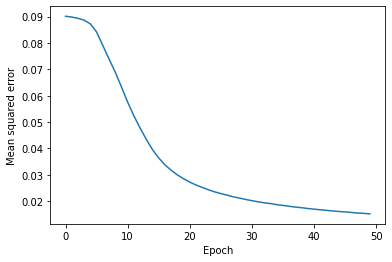

In [21]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

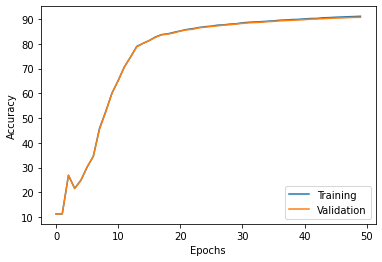

In [22]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [23]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 90.73%


In [24]:
minibatch_gen = minibatch_generator(X_test, y_test, minibatch_size)
    
probs = []
labels = []
for i, (features, targets) in enumerate(minibatch_gen):

    probas, _ = model.forward(features)
    probs.append(np.exp(probas)/ np.exp(probas).sum(1)[:, None])
    onehot_targets = int_to_onehot(targets, num_labels=10)
    labels.append(onehot_targets)

probs = np.vstack(probs)
labels = np.vstack(labels)

In [25]:
roc_auc_score(labels, probs, average='macro', multi_class='ovr')

0.990541960797436

Plot failure cases:

In [27]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

probas, _ = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

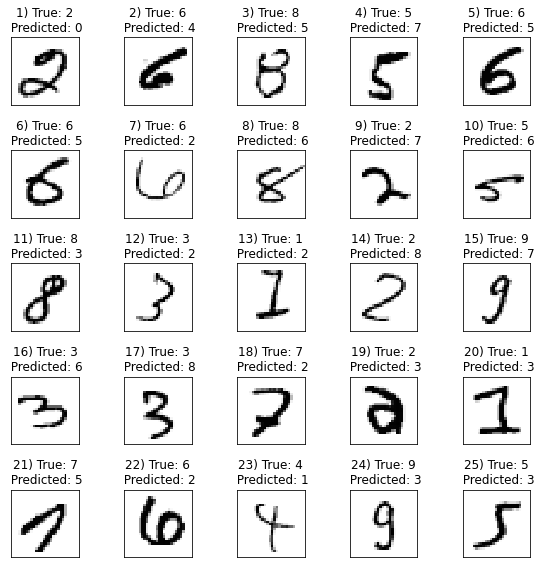

In [28]:
fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()